In [2]:
# installing necessary libiaries
!pip install chembl-webresource-client
!pip install rdkit-pypi
!pip install mordred
!pip install pubchempy

In [3]:
# importing libiraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from chembl_webresource_client.new_client import new_client
import rdkit
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors
import pubchempy as pubchem

In [4]:
# Importing the Dataset
df = pd.read_csv("GDSC1_fitted_dose_response_27Oct23.csv")
df.head()
print(df.shape)

(333161, 19)


In [5]:
# selecting cell lines
cell_lines = df['CELL_LINE_NAME']
selected_cell_line = df[df['CELL_LINE_NAME'] == cell_lines.value_counts().sort_values(ascending=False).index[0]]
selected_cell_line.shape
cell_lines.value_counts().sort_values(ascending=False)

,count
CELL_LINE_NAME,
SK-MEL-2,402
TGW,400
MFM-223,400
SNU-C1,398
COLO-684,398
...,...
EW-12,41
ECC12,32
KP-N-RT-BM-1,25


In [6]:
import pubchempy as pcp
import time
list_compounds = selected_cell_line['DRUG_NAME']
smiles = np.array(['Name', 'iupac', 'smiles'])
# Use .iterrows() to iterate through the Series with index and value
for index, compound in list_compounds.items():
    # Add a delay to avoid overloading the server
    time.sleep(0.5)
    try:
        results = pcp.get_compounds(compound, 'name')
        smiles = np.vstack((smiles, [compound, results[0].iupac_name, results[0].canonical_smiles]))
    except IndexError:
        smiles = np.vstack((smiles, [compound, 'NF', 'NF']))
    except pcp.PubChemHTTPError as e:
        if e.status_code == 503:
            # If the server is busy, wait a bit longer and try again
            time.sleep(5)
            results = pcp.get_compounds(compound, 'name')
            smiles = np.vstack((smiles, [compound, results[0].iupac_name, results[0].canonical_smiles]))
        else:
            # If a different error occurs, raise it
            raise e
smiles = pd.DataFrame(smiles[1:], columns=smiles[0])
smiles

,Name,iupac,smiles
0,Erlotinib,"N-(3-ethynylphenyl)-6,7-bis(2-methoxyethoxy)qu...",COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...
1,Rapamycin,"(1R,9S,12S,15R,16E,18R,19R,21R,23S,24E,26E,28E...",CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...
2,Sunitinib,N-[2-(diethylamino)ethyl]-5-[(Z)-(5-fluoro-2-o...,CCN(CC)CCNC(=O)C1=C(NC(=C1C)C=C2C3=C(C=CC(=C3)...
3,PHA-665752,"(3Z)-5-[(2,6-dichlorophenyl)methylsulfonyl]-3-...",CC1=C(NC(=C1C(=O)N2CCCC2CN3CCCC3)C)C=C4C5=C(C=...
4,MG-132,benzyl N-[(2S)-4-methyl-1-[[(2S)-4-methyl-1-[[...,CC(C)CC(C=O)NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=...
...,...,...,...
397,Refametinib,"N-[3,4-difluoro-2-(2-fluoro-4-iodoanilino)-6-m...",COC1=CC(=C(C(=C1NS(=O)(=O)C2(CC2)CC(CO)O)NC3=C...
398,Pictilisib,4-[2-(1H-indazol-4-yl)-6-[(4-methylsulfonylpip...,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...
399,Pevonedistat,"[(1S,2S,4R)-4-[4-[[(1S)-2,3-dihydro-1H-inden-1...",C1CC2=CC=CC=C2C1NC3=C4C=CN(C4=NC=N3)C5CC(C(C5)...
400,PFI-3,"(E)-1-(2-hydroxyphenyl)-3-[(1R,4R)-5-pyridin-2...",C1C2CN(C1CN2C3=CC=CC=N3)C=CC(=O)C4=CC=CC=C4O


In [7]:
smiles['smiles'].value_counts()

,count
smiles,
NF,73
C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N3)F)C(CCC(F)(F)F)C(=O)N)Cl,2
C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=NNC(=O)C5=CC=CC=C54)F,2
CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=C5C=NNC5=CC=C4)N6CCOCC6,2
COC1=CC(=C(C(=C1NS(=O)(=O)C2(CC2)CC(CO)O)NC3=C(C=C(C=C3)I)F)F)F,2
...,...
COC1=CC(=CC(=C1)C2=CC3=C4C(=CN=C3C=C2)C=CC(=O)N4C5=CC(=C(C=C5)N6CCNCC6)C(F)(F)F)OC,1
CC1=NC=C(C=C1)OC2=C(C=C(C=C2)NC3=NC=NC4=C3C=C(C=C4)C=CCNC(=O)COC)C,1
CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C5=C(C=C(C=C5)OCCN6CCOCC6)SC4=N3,1


In [8]:
# Reset the index of both dataframes to ensure proper concatenation
selected_cell_line = selected_cell_line.reset_index(drop=True)
smiles = smiles.reset_index(drop=True)

# Concatenate the two dataframes horizontally
concatenated_df = pd.concat([selected_cell_line, smiles['smiles']], axis=1)
concatenated_df

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE,smiles
0,GDSC1,342,15646269,905955,SK-MEL-2,SIDM00082,SKCM,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,3.394001,0.985284,0.032859,0.785492,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...
1,GDSC1,342,15646572,905955,SK-MEL-2,SIDM00082,SKCM,3,Rapamycin,MTORC1,PI3K/MTOR signaling,1045,Y,0.000391,0.1,-1.113085,0.945620,0.135881,0.569712,CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...
2,GDSC1,342,15646643,905955,SK-MEL-2,SIDM00082,SKCM,5,Sunitinib,"PDGFR, KIT, VEGFR, FLT3, RET, CSF1R",RTK signaling,1045,Y,0.031250,8.0,4.013588,0.970974,0.068558,0.945589,CCN(CC)CCNC(=O)C1=C(NC(=C1C)C=C2C3=C(C=CC(=C3)...
3,GDSC1,342,15646658,905955,SK-MEL-2,SIDM00082,SKCM,6,PHA-665752,MET,RTK signaling,1045,Y,0.007813,2.0,3.092390,0.980721,0.119597,0.396507,CC1=C(NC(=C1C(=O)N2CCCC2CN3CCCC3)C)C=C4C5=C(C=...
4,GDSC1,342,15646669,905955,SK-MEL-2,SIDM00082,SKCM,9,MG-132,"Proteasome, CAPN1",Protein stability and degradation,1045,Y,0.003906,1.0,2.369072,0.980196,0.070962,1.688235,CC(C)CC(C=O)NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,GDSC1,342,15646465,905955,SK-MEL-2,SIDM00082,SKCM,1526,Refametinib,"MEK1, MEK2",ERK MAPK signaling,1046,Y,0.019531,5.0,-1.542607,0.441238,0.088111,-1.916767,COC1=CC(=C(C(=C1NS(=O)(=O)C2(CC2)CC(CO)O)NC3=C...
398,GDSC1,342,15646466,905955,SK-MEL-2,SIDM00082,SKCM,1527,Pictilisib,PI3K (class 1),PI3K/MTOR signaling,1046,Y,0.015625,4.0,1.439194,0.872167,0.081591,0.455946,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...
399,GDSC1,342,15646467,905955,SK-MEL-2,SIDM00082,SKCM,1529,Pevonedistat,NAE,Other,1046,Y,0.003906,1.0,-0.809756,0.782186,0.048353,-0.676150,C1CC2=CC=CC=C2C1NC3=C4C=CN(C4=NC=N3)C5CC(C(C5)...
400,GDSC1,342,15646469,905955,SK-MEL-2,SIDM00082,SKCM,1530,PFI-3,"PB1, SMARCA4, SMARCA2",Chromatin other,1025,Y,0.039063,10.0,5.665698,0.991941,0.028880,1.827492,C1C2CN(C1CN2C3=CC=CC=N3)C=CC(=O)C4=CC=CC=C4O


In [9]:
df_final = concatenated_df[['DRUG_NAME', 'LN_IC50', 'smiles']]
df_final['LN_IC50'].describe()

,LN_IC50
count,402.000000
mean,2.069341
std,2.666377
min,-6.008461
25%,0.558932
50%,2.518864
75%,4.088666
max,8.577464


In [10]:
# Lipindki descriptors
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        # Check if elem is a valid SMILES string before converting
        if isinstance(elem, str):
            mol=Chem.MolFromSmiles(elem)
            moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [11]:
lipinski_df = lipinski(df_final.smiles)
df_final  =  pd.concat([df_final,lipinski_df], axis=1)
df_final.head()

,DRUG_NAME,LN_IC50,smiles,MW,LogP,NumHDonors,NumHAcceptors
0,Erlotinib,3.394001,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,393.443,3.40510,1.0,7.0
1,Rapamycin,-1.113085,CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,914.187,6.18060,3.0,13.0
2,Sunitinib,4.013588,CCN(CC)CCNC(=O)C1=C(NC(=C1C)C=C2C3=C(C=CC(=C3)...,398.482,3.33494,3.0,3.0
3,PHA-665752,3.092390,CC1=C(NC(=C1C(=O)N2CCCC2CN3CCCC3)C)C=C4C5=C(C=...,641.621,6.10534,2.0,5.0
4,MG-132,2.369072,CC(C)CC(C=O)NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=...,475.630,3.58820,3.0,5.0


In [12]:
def RDkit_descriptors(smiles):
  mols = [Chem.MolFromSmiles(i) for i in smiles]
  calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
  desc_names = calc.GetDescriptorNames()

  Mol_descriptors =[]
  for mol in mols:
      # add hydrogens to molecules
      mol=Chem.AddHs(mol)
      # Calculate all 200 descriptors for each molecule
      descriptors = calc.CalcDescriptors(mol)
      Mol_descriptors.append(descriptors)
  return Mol_descriptors,desc_names

In [13]:
Mol_descriptors,desc_names = RDkit_descriptors(df_final.smiles)
df_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_final = pd.concat([df_descriptors, df_final], axis=1)
df_final.drop('MW', axis=1, inplace=True)
df_final.smiles.count()

402

In [14]:
df_final = df_final[df_final['smiles'] != "NF"]
df_final.smiles.count()

329

In [15]:
df_features = df_final[['smiles', 'DRUG_NAME']]
df_features.to_csv('features.smi', sep='\t', index= False, header=False)

In [16]:
#!unzip padel.zip
!sh padel.sh

Processing Erlotinib in features.smi (1/61). 
Processing Rapamycin in features.smi (2/61). 
Processing Sunitinib in features.smi (3/61). Average speed: 2.85 s/mol.
Processing PHA-665752 in features.smi (4/61). Average speed: 2.04 s/mol.
Processing MG-132 in features.smi (5/61). Average speed: 2.03 s/mol.
Processing Paclitaxel in features.smi (6/61). Average speed: 1.68 s/mol.
Processing Cyclopamine in features.smi (7/61). Average speed: 1.41 s/mol.
Processing AZ628 in features.smi (8/61). Average speed: 1.37 s/mol.
Processing Sorafenib in features.smi (9/61). Average speed: 1.35 s/mol.
Processing Tozasertib in features.smi (10/61). Average speed: 1.18 s/mol.
Processing Imatinib in features.smi (11/61). Average speed: 1.12 s/mol.
Processing NVP-TAE684 in features.smi (12/61). Average speed: 1.01 s/mol.
Processing Saracatinib in features.smi (14/61). Average speed: 0.92 s/mol.
Processing Crizotinib in features.smi (13/61). Average speed: 1.00 s/mol.
Processing Z-LLNle-CHO in features.smi

In [17]:
descriptors = pd.read_csv('descriptors_output.csv')
descriptors

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,Erlotinib,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Sunitinib,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rapamycin,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,PHA-665752,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,MG-132,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,DMOG,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57,JQ12,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,FTI-277,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,Shikonin,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Check for duplicate columns in df_final
duplicate_columns = df_final.columns[df_final.columns.duplicated()]

# Print the duplicate columns
print(f"Duplicate columns: {duplicate_columns}")

Duplicate columns: Index(['NumHDonors', 'NumHAcceptors'], dtype='object')


In [19]:
df_final.rename(columns={'NumHDonors': 'Donors', 'NumHAcceptors':'Acceptors'}, inplace=True)
df_final.drop(columns=['Acceptors','Donors'], inplace=True)

In [20]:
#%pip install scipy==1.11.4
from scipy.interpolate import interp1d
#!pip install pycaret

from pycaret.regression import *

# Assuming 'df_final' is your dataframe with features and target variable 'LN_IC50'
# You might need to preprocess your data further before using PyCaret

# Setup PyCaret for regression
reg = setup(data = df_final, target = 'LN_IC50', session_id=123)

# Compare different models
best_model = compare_models()

# Tune the best model
tuned_best_model = tune_model(best_model)

# Evaluate the model
evaluate_model(tuned_best_model)

# Save the model
save_model(tuned_best_model, 'my_best_model')

,Description,Value
0,Session id,123
1,Target,LN_IC50
2,Target type,Regression
3,Original data shape,"(329, 210)"
4,Transformed data shape,"(329, 210)"
5,Transformed train set shape,"(230, 210)"
6,Transformed test set shape,"(99, 210)"
7,Numeric features,207
8,Categorical features,2
9,Rows with missing values,0.6%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,2.2064,7.4404,2.6909,-0.0666,0.5282,1.8930,1.0950
dummy,Dummy Regressor,2.2013,7.4907,2.6969,-0.0681,0.5242,1.8980,0.1270
knn,K Neighbors Regressor,2.4301,9.0655,2.9673,-0.3269,0.6779,2.1471,0.1330
en,Elastic Net,2329238.8170,1247829027875584.7500,11170629.1974,-326082581377555.4375,0.9224,1161412.4916,0.2330
lasso,Lasso Regression,2331395.7413,1250141109852780.5000,11180973.3681,-326686774454201.6875,0.9278,1162487.9743,0.1470
lr,Linear Regression,6435770.8276,9526397100229078.0000,30864864.5475,-2489437325367379.0000,0.8878,3209023.0244,0.6320
llar,Lasso Least Angle Regression,7039333.0248,11397001208736288.0000,33759447.3443,-2978263440813631.0000,0.9319,3509972.9498,0.1630
omp,Orthogonal Matching Pursuit,7039333.0821,11397001208736290.0000,33759447.4166,-2978263440813631.0000,0.8881,3509972.9242,0.1330
ridge,Ridge Regression,59638603.6582,818055440376449664.0000,286016687.3808,-213774181998356160.0000,0.9299,29737169.7972,0.1370
br,Bayesian Ridge,486778031823964348612608.0000,54499155858516582101750962441865895163324209823744.0000,2334505426992733148413952.0000,-14241715033267200361942464499361962993868588711936.0000,32.7199,242718637057706549051392.0000,0.1390


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9164,12.0639,3.4733,-0.1562,0.5722,1.8315
1,2.1293,7.0124,2.6481,0.0476,0.5586,5.2196
2,2.1294,6.8920,2.6253,-0.0166,0.5931,1.4957
3,2.3451,9.6769,3.1108,-0.0785,0.5156,1.1884
4,2.2006,7.7628,2.7862,0.1056,0.5840,1.2452
5,1.9320,5.6875,2.3849,0.0480,0.5160,0.7619
6,1.7066,4.0073,2.0018,-0.0472,0.5641,2.3454
7,1.6091,3.5024,1.8715,0.0093,0.5188,2.3895
8,2.3728,7.5321,2.7445,-0.0681,0.5519,1.4798


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['MaxEStateIndex', 'MinEStateIndex',
                                              'MaxAbsEStateIndex',
                                              'MinAbsEStateIndex', 'qed',
                                              'MolWt', 'HeavyAtomMolWt',
                                              'ExactMolWt',
                                              'NumValenceElectrons',
                                              'NumRadicalElectrons',
                                              'MaxPartialCharge',
                                              'MinPartialCharge',
                                              'MaxAbsPartialCharge',
                                              'MinAbsPartialCharge',
                                              'FpDensityMo...
                 ('rest_encoding',
                  TransformerWrapper(include=['DRUG_NAME', '

In [37]:
data_for_prediction = df_final.copy()

# Keep a copy of 'LN_IC50' for comparison
actual_LN_IC50 = data_for_prediction['LN_IC50']

# Drop the target variable ('LN_IC50') from the prediction data:
data_for_prediction.drop('LN_IC50', axis=1, inplace=True)

# Make predictions using the modified data:
predictions = predict_model(tuned_best_model, data=data_for_prediction)

# Add the actual 'LN_IC50' values back to the predictions DataFrame
predictions['LN_IC50'] = actual_LN_IC50
predictions[['LN_IC50', 'prediction_label']]

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


,LN_IC50,prediction_label
0,3.394001,3.924207
1,-1.113085,-2.418300
2,4.013588,3.857225
3,3.092390,2.972183
4,2.369072,1.487346
...,...,...
397,-1.542607,-2.242410
398,1.439194,1.694475
399,-0.809756,-1.177579
400,5.665698,2.419815


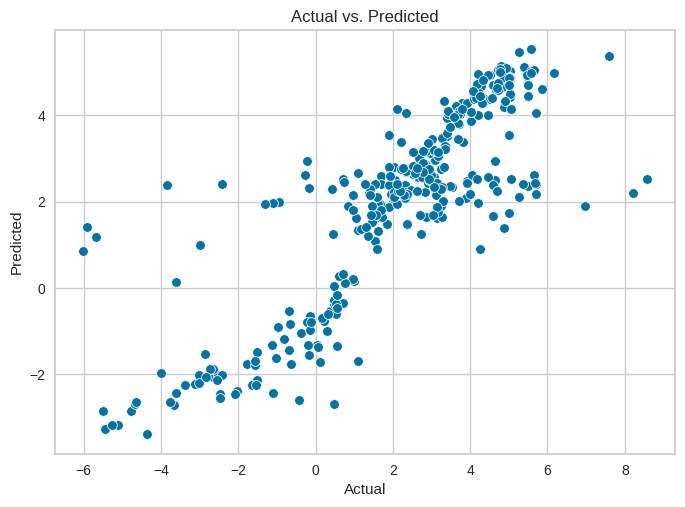

In [34]:
# Compare actual and predicted values using the 'prediction_label' column from PyCaret
predictions[['LN_IC50', 'prediction_label']]
sns.scatterplot(x=predictions['LN_IC50'], y=predictions['prediction_label'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()